# Otter populations in California

Project 1

Gail Romer and Mellie Zito

In [17]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_csv

from matplotlib.pyplot import *

In [18]:
filename = 'Otterdata.csv'
tables = read_csv(filename, header=0, index_col=0, decimal='M');

In [19]:
pup_total = tables.pups
otter_total = tables.total
mature_total = otter_total - pup_total;

Reads in a data table for otter pup and total otter populations. The number of pups is subtracted from the total to get the number of mature otters.

In [20]:
pofo = 0.4 #percentage of female otters
pomo = 1 - pofo 

female_pups = pup_total * pofo
male_pups = pup_total * pomo

f_mature = (otter_total - pup_total) * pofo
m_mature = (otter_total - pup_total) * pomo;

Based on at least two articles, there have been less female otters than male otters in recent years due to unknown factors. 
We break mature otters and pups into male and female and set male otters as a greater percentage of the population.

In [21]:
def plot_results(male, female, timeseries, title):
    """Plot the estimates and the model.
    
    male and female: TimeSeries of population estimates broken into male and female
    timeseries: TimeSeries of simulation results
    title: string
    """
    
    plot(female+male, '--', label='otters')
    
    
    plot(timeseries, color='gray', label='model_otters')
    
    decorate(xlabel='Year', 
             ylabel='Otter Population',
             title=title)

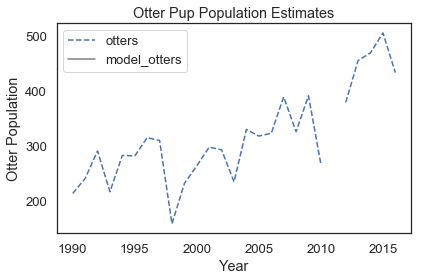

In [22]:
empty = TimeSeries()
plot_results(male_pups, female_pups,  empty, 'Otter Pup Population Estimates')

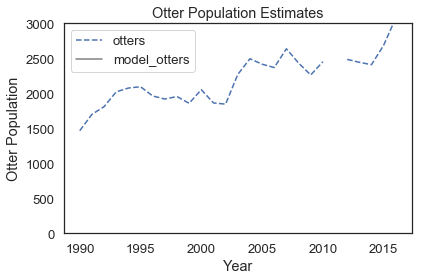

In [23]:
ylim(0, 3000)

plot_results(f_mature, m_mature, empty, 'Otter Population Estimates')

The populations of otter pups and mature otters was plotted based on the data table

### What is the smallest death rate of female otters that will cause the California otter population to go extinct in the next 20 years?

Although otter populations are on the rise now, female otter populations are disproportionally affected and lower than male otter populations. If this disparity in female otters continues, it could affect birth rates, and potentially affect otter pup populations and then total otter populations. It's important to analyze what percentage of female otters dying off would cause otters to die in California, in order to maintain stable otter populations in California.



To answer this question, we will start by reviewing past otter populations and find a common trend. We then will sweep the female death rate to predict the point where the death rate causes the California otter population to go extinct.

In [24]:
'''State initialized with initial population numbers broken into groups'''

init_f_pups = get_first_value(female_pups)
init_m_pups = get_first_value(male_pups)
init_f_mature = get_first_value(f_mature)
init_m_mature = get_first_value(m_mature)

init_state = State(f_pups=init_f_pups, m_pups=init_m_pups, f_mature=init_f_mature, m_mature=init_m_mature)

,values
f_pups,85.6
m_pups,128.4
f_mature,586.4
m_mature,879.6


Birth rate per female is < 1 per year


             https://seaworld.org/animal-info/animal-infobooks/otters/birth-and-care-of-young                
                
Sea otter gestation range from four to nine months, with an average of six months.
Sea otters give birth throughout the year, with peaks in late May and June for Alaska otters, and March and September for California otters.
Sea otters are capable of giving birth every year, but females usually experience much longer birth intervals.
             https://www.biologicaldiversity.org/species/mammals/sea_otter/natural_history.html
                
                
Female otters reach sexual maturity at three years of age, and males follow at five to six years
Male sea otters live between 10 and 15 years, while females live slightly longer, from 15 to 20 years

In [25]:
f_birth_rate = .035
m_birth_rate = f_birth_rate 

maturation_rate = .16
f_death_rate = .0008
m_death_rate = .0008
t_0 = 1990
t_mid = 2015
t_end = 2035

'''Birth rates, maturation rate, and death rates are set and adjusted to fit data's trends
t_0, t_mid, and t_end are set based on the years the data covers and the "current year" (2015) 
to then make projections into the next 20 years
The initial state is also added to the system to then be modified for each time step
'''

system = System(f_birth_rate = f_birth_rate,
                m_birth_rate = m_birth_rate,
                maturation_rate = maturation_rate,
                f_death_rate = f_death_rate,
                m_death_rate = m_death_rate, 
                t_0 = t_0,
                t_mid = t_mid,
                t_end = t_end,
                state = init_state,
                state_2 = init_state)

,values
f_birth_rate,0.035
m_birth_rate,0.035
maturation_rate,0.16
f_death_rate,0.0008
m_death_rate,0.0008
t_0,1990
t_mid,2015
t_end,2035
state,f_pups 85.6 m_pups 128.4 f_mature ...
state_2,f_pups 85.6 m_pups 128.4 f_mature ...


In [26]:
def update_func1(state, t, system):
    '''the initial populations from state and the rates from system are used to
    update the births, pups that become mature otters, the deaths, and the new populations.
    '''
    
    f_births = system.f_birth_rate * state.f_mature #Number of new pups born is female mature otters times birth rate
    
    m_births = system.m_birth_rate * state.f_mature
    
    f_pup_deaths = system.f_death_rate * state.f_pups #Number of pup otter deaths is fixed death rate times number of pups
    
    m_pup_deaths = system.m_death_rate * state.f_pups
    
    f_pups = state.f_pups - f_pup_deaths #Pup numbers are updated by subtracting deaths
    
    m_pups = state.m_pups - m_pup_deaths
    
    f_maturlings = system.maturation_rate * state.f_pups #Number of mature otters is maturation rate times updated pup pop
    
    m_maturlings = system.maturation_rate * state.m_pups
        
    f_deaths = f_death_rate * state.f_mature #Number of otter deaths is fixed death rate times number of otters
    
    m_deaths = system.m_death_rate * state.m_mature
    
    f_otters = state.f_mature - f_deaths + f_maturlings #Number of mature otters is initial pop - deaths + newly matured otters
    
    m_otters = state.m_mature - m_deaths + m_maturlings
    
    f_pups = state.f_pups + f_births - f_maturlings #Number of pups is initial pop + births - otters that matured
    
    m_pups = state.m_pups + m_births - m_maturlings
    
    
    return State(f_pups=f_pups, m_pups=m_pups, f_mature=f_otters, m_mature=m_otters)

Update function 1 updates populations of the model for every year, based on system birth, maturation, and death rates. Update function 2 is the same as update function 1, except that it replaces the given static death rate for female otters with death_rate. death_rate is a changing value for female otter death rate from a sweepseries.

In [27]:
def update_func2(state, t, death_rate, system):
    '''the initial populations from state and the rates from system are used to
    update the births, pups that become mature otters, the deaths, and the new populations.
    '''
    
    f_births = system.f_birth_rate * state.f_mature #Number of new pups born is female mature otters times birth rate
    
    m_births = system.m_birth_rate * state.f_mature
    
    
    
    f_pup_deaths = system.f_death_rate * state.f_pups #Number of pup otter deaths is fixed death rate times number of pups
    
    m_pup_deaths = system.m_death_rate * state.f_pups
    
    
    
    f_pups = state.f_pups - f_pup_deaths #Pup numbers are updated by subtracting deaths
    
    m_pups = state.m_pups - m_pup_deaths
    
    
    f_maturlings = system.maturation_rate * f_pups #Number of mature otters is maturation rate times updated pup pop
    
    m_maturlings = system.maturation_rate * m_pups
    
    
    m_mature = state.m_mature + m_maturlings #Number of mature otters is initial mature otters and ones that matured
    
    f_mature = state.f_mature + f_maturlings
        
        
    f_deaths = death_rate * f_mature #Number of f otter deaths is death rate from sweepseries times number of f otters
    
    m_deaths = m_death_rate * m_mature #Number of m otter deaths is fixed death rate times number of m otters
    
    
    
    f_otters = state.f_mature - f_deaths #Number of mature otters is initial pop - deaths + newly matured otters
    
    m_otters = state.m_mature - m_deaths
    
    
    
    f_pups = state.f_pups + f_births - f_maturlings #Number of pups is initial pop + births - otters that matured 
    
    m_pups = state.m_pups + m_births - m_maturlings
    
    
    
    return State(f_pups=f_pups, m_pups=m_pups, f_mature=f_otters, m_mature=m_otters)

In [28]:
def run_simulation1(system, update_func):
    """Simulate the system using any update function.
    
    state: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries of mature otters and otter pups
    """
    results_mature = TimeSeries()
    results_pups = TimeSeries()
    
    state = system.state
    results_mature[system.t_0] = state.f_mature + state.m_mature
    results_pups[system.t_0] = state.f_pups + state.m_pups
    
    for t in linrange(system.t_0, system.t_mid):
        state = update_func(state, t, system)
        results_mature[t+1] = state.f_mature + state.m_mature
        results_pups[t+1] = state.f_pups + state.m_pups
    return results_mature, results_pups

Run simulation 1 uses update function to calculate new populations from the 1990 to 2015. Run simulation 2 is the same as run simulation 1, but predicts the population for 20 years past 2015, using t_0 = 1990, t_mid = 2015, and t_end = 2035. 

In [29]:
def run_simulation2(system, death_rate, update_func):
    """Simulate the system using any update function.
    
    init: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries of mature otters and otter pups
    """
    results_mature = TimeSeries()
    results_pups = TimeSeries()
    
    state = system.state
    results_mature[system.t_mid] = state.f_mature + state.m_mature
    results_pups[system.t_mid] = state.f_pups + state.m_pups
        
    for t in linrange(system.t_mid+1, system.t_end):
        state = update_func(state, t, death_rate, system)
        results_mature[t+1] = state.f_mature + state.m_mature
        results_pups[t+1] = state.f_pups + state.m_pups
    return results_mature, results_pups

In [30]:
'''Results from run simulation 1 were used to fit the model to the data for the population between 1990 and 2015. 
Run simulation 2 is then used to create multiple models for the sweep of female otter death rates.
'''

results_mature1 = run_simulation1(system, update_func1)[0]; #Model results for 1990-2015 mature
results_pups1 = run_simulation1(system, update_func1)[1]; #Model results for 1990-2015 pups

mature_2015 = get_last_value(results_mature1) #Gets final value of results_mature1, to initialize the prediction model
pups_2015 = get_last_value(results_pups1) #Gets final value of results_pups1, to initialize the prediction model


state2 = State(f_pups = pofo * pups_2015, m_pups = pomo * pups_2015, 
               f_mature = pofo * mature_2015, m_mature = pomo * mature_2015)

system_2 = System(f_birth_rate = f_birth_rate,
                m_birth_rate = m_birth_rate,
                maturation_rate = maturation_rate,
                f_death_rate = f_death_rate,
                m_death_rate = m_death_rate, 
                t_0 = t_0,
                t_mid = t_mid,
                t_end = t_end,
                state = state2)

death_rate_array = linspace(0, 0.5, 5) # Array for death rate sweep

array([0.   , 0.125, 0.25 , 0.375, 0.5  ])

### Results:

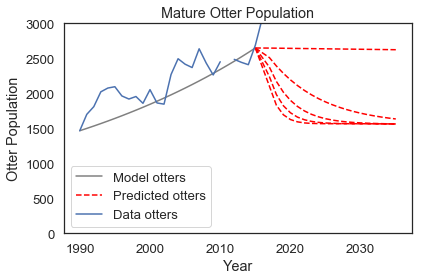

In [31]:
plot(results_mature1, color='gray', label = 'Model otters')

sweep_pups = SweepSeries() # Array to hold swept pup data
sweep_mature = SweepSeries() # Array to hold swept mature data

for death_rate in death_rate_array: # Sweeping death rate
    results_mature = run_simulation2(system_2, death_rate, update_func2)[0]; ## runs simulation calling varying death rate
    results_pups = run_simulation2(system_2, death_rate, update_func2)[1];   ## returns mature and pup populations 

    sweep_pups = results_pups
    sweep_mature = results_mature
  

    plot(sweep_mature, "--", color = 'red') # plots mature populations for each death rate
    
empty = TimeSeries()

plot(empty, "--", color = 'red', label = 'Predicted otters')  # lables sweep lines once instead of 5 times  

plot(f_mature+m_mature, label='Data otters') # plots otter data

ylim(0, 3000) # scales y axis

decorate(xlabel='Year', 
        ylabel='Otter Population',
        title= 'Mature Otter Population') # titles graph and lables axis

Swept death rates:
0.0
0.125
0.25
0.375
0.5


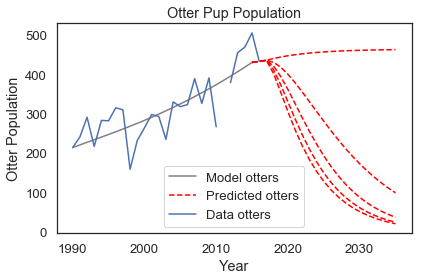

In [32]:
plot(results_pups1, color='gray', label = 'Model otters')

sweep_pups = SweepSeries()# Array to hold swept pup data
sweep_mature = SweepSeries() # Array to hold swept mature data

print("Swept death rates:")

for death_rate in death_rate_array: # Sweeping death rate
    results_mature = run_simulation2(system_2, death_rate, update_func2)[0]; ## runs simulation calling varying death rate
    results_pups = run_simulation2(system_2, death_rate, update_func2)[1];   ## returns mature and pup populations

    sweep_pups = results_pups
    sweep_mature = results_mature
    
    print(death_rate)
    
    plot(sweep_pups, "--", color = 'red') # plots mature populations for each death rate
    
empty = TimeSeries()

plot(empty, "--", color = 'red', label = 'Predicted otters') # lables sweep lines once instead of 5 times

plot(female_pups+male_pups, label='Data otters') # plots otter data

decorate(xlabel='Year', 
        ylabel='Otter Population',
        title='Otter Pup Population')

### Interpretation: 
According to our model, if female death rates grow past 30%, the otter pup population will approach zero by the year 2030. As the pup population fades out, the mature population quickly declines to 1500, though if males had a more reasonable death rate, the population would likely be near extinction by this point.

We didn't have reliable data for birth rate, maturation rate, and death rate. This caused an issue with the final mature otter graph for mature otters because our static death rate (from the fitting of the model to the original data) was so low that the otters didn't die out and instead leveled out at the male mature otter population number. For future graphs, we would need to adjust rates to be more realistic or find better data relating to the rates.

One of the assumptions that we made is that, as the number of female otters declines, the number of births will decline proportionally. We also used percentages to represent maturation rate instead of accounting for the offset in time for otter pups to mature. These percentages also didn't account for the difference between male and female otter pup maturation rates (female otters mature in 3 years, whereas male otters mature in 5). Our original death rates didn't consider the life span of otters, and was purely based on the curve fit to the data. Tracking the age of otters would have made the model more accurate, but would require more reliable data and would significantly complicate the model.